In [1]:
# coding: UTF-8
import os
import torch
import numpy as np
import pickle as pkl
from tqdm import tqdm
import time
from datetime import timedelta
import time
import torch
import numpy as np
from train_eval import train, init_network
from importlib import import_module
import argparse
dataset = 'Newtrain'  # 数据集

# 搜狗新闻:embedding_SougouNews.npz, 腾讯:embedding_Tencent.npz, 随机初始化:random
embedding = 'embedding_Newtrain_300.npz'

model_name = 'TextCNN'  # 'TextRCNN'  # TextCNN, TextRNN, FastText, TextRCNN, TextRNN_Att, DPCNN, Transformer


x = import_module('models.' + model_name)
config = x.Config(dataset, embedding)
config.pad_size = 64

MAX_VOCAB_SIZE = 20000  # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'  # 未知字，padding符号
ues_word = True
from utils import get_time_dif, build_vocab, build_dataset2, build_iterator2


vocab, train, test = build_dataset2(config, ues_word)

Vocab size: 12678


8000it [00:00, 66350.48it/s]
2653it [00:00, 64312.94it/s]


In [2]:
import torch.nn.functional as F
import torch.nn as nn
from model_myself import *

train_iter = build_iterator2(train, config)
test_iter = build_iterator2(test, config)
# train_iter.__next__()

config.n_vocab = len(vocab)
if model_name == 'TextRNN':
    model = text_rnn(config).to(config.device)
if model_name == 'TextCNN':
    model = text_cnn(config).to(config.device)
    
if model_name != 'Transformer':
    init_network(model)
print(model.parameters)

<bound method Module.parameters of text_cnn(
  (embedding): Embedding(12678, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 256, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 256, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 256, kernel_size=(4, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=768, out_features=10, bias=True)
)>


In [3]:
import numpy as np
import torch
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import time
from utils import get_time_dif
from tensorboardX import SummaryWriter
from collections import defaultdict
from train_eval import train_zhuti

train_zhuti(config, model, train_iter, test_iter)

Epoch [1/20]
Iter:      0,  Train Loss:  0.71,  Train Acc: 42.42%,  Val Loss:  0.39,  Val Acc: 79.59%,  Time: 0:00:00 *improve
Iter:      0,  Train precision: 54.65%,  Train recall: 51.80%,  Val precision: 54.24%,  Val recall: 55.31%,  Time: 0:00:00 *improve
Iter:     10,  Train Loss:  0.49,  Train Acc: 84.53%,  Val Loss:  0.34,  Val Acc: 85.24%,  Time: 0:00:00 *improve
Iter:     10,  Train precision: 53.04%,  Train recall: 66.19%,  Val precision: 62.38%,  Val recall: 61.87%,  Time: 0:00:00 *improve
Iter:     20,  Train Loss:  0.33,  Train Acc: 87.19%,  Val Loss:  0.29,  Val Acc: 91.54%,  Time: 0:00:01 *improve
Iter:     20,  Train precision: 52.54%,  Train recall: 84.53%,  Val precision: 92.56%,  Val recall: 63.01%,  Time: 0:00:01 *improve
Iter:     30,  Train Loss:  0.31,  Train Acc: 89.84%,  Val Loss:  0.25,  Val Acc: 92.83%,  Time: 0:00:01 *improve
Iter:     30,  Train precision: 61.12%,  Train recall: 92.28%,  Val precision: 85.92%,  Val recall: 74.27%,  Time: 0:00:01 *improve
Ite

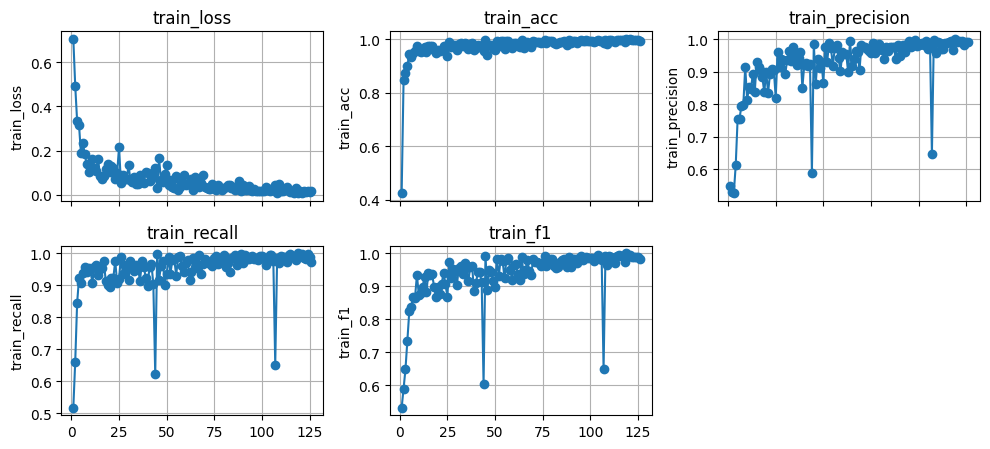

In [4]:
import json

with open(config.log_path + '/train_dict.json', 'r', encoding='utf-8') as file:
    train_dict = json.load(file)
with open(config.log_path + '/test_dict.json', 'r', encoding='utf-8') as file:
    test_dict = json.load(file)
import matplotlib.pyplot as plt

epochs = range(1, len(train_dict['train_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(train_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(train_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()

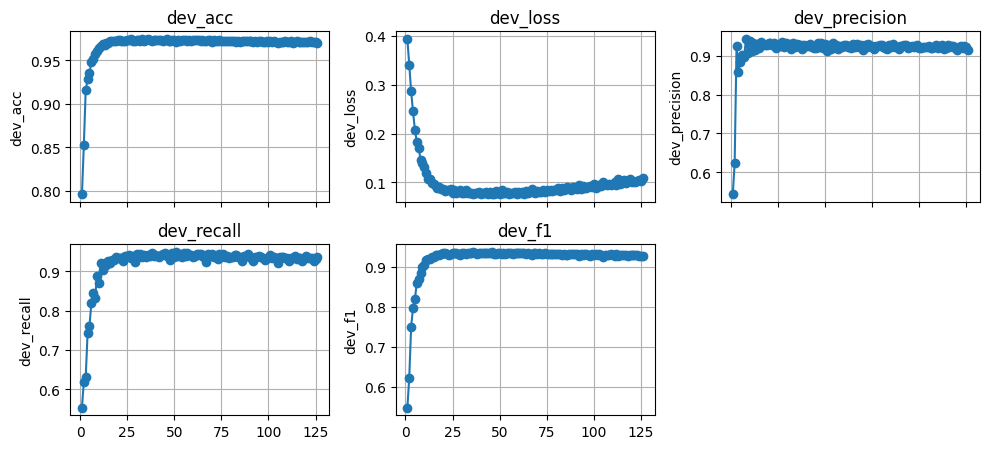

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_dict['dev_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(test_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(test_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()